In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model("openai:gpt-4.1")

In [3]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph = graph_builder.compile()

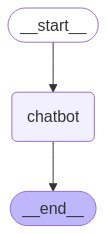

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today? 😊
Goodbye!


In [8]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

Assistant: My knowledge cutoff is in 2022. I aim to be direct and honest about this limitation while focusing on providing the most helpful and accurate responses I can within that scope. If you have a question about more recent events, I'd be happy to help you find reliable current sources.
Goodbye!


### add tools

In [10]:
from dotenv import load_dotenv
from langchain_tavily import TavilySearch

load_dotenv()

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'content': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges | by Story_Teller | Medium LangGraph Basics: Understanding State, Schema, Nodes, and Edges LangGraph Basics: Understanding State, Schema, Nodes, and Edges These predefined structures in the messaging app are synonymous with the schema of the state in LangGraph. Just as a messaging app ensures all interactions (messages) follow a consistent format, the schema in LangGraph ensures the state passed along edges is structured and interpretable. This static schema allows nodes to rely on a consistent state format, ensuring seamless communication along edges throughout the graph. In this article, we explored t

In [11]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [13]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

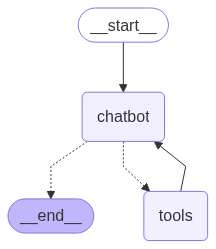

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "LangGraph AI framework", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "GitHub - langchain-ai/langgraphjs: Framework to build resilient ...", "url": "https://github.com/langchain-ai/langgraphjs", "content": "package.json | package.json |  |  LangGraph \u2014 used by Replit, Uber, LinkedIn, GitLab and more \u2014 is a low-level orchestration framework for building controllable agents. While langchain provides integrations and composable components to streamline LLM application development, the LangGraph library enables agent orchestration \u2014 offering customizable architectures, long-term memory, and human-in-the-loop to reliably handle complex tasks. To learn more about how to use LangGraph, check out the docs. Get started quickly by building a full-stack LangGraph application using the create-agent-chat-app CLI: Why use LangGraph? LangGraph is built for developers who want to build powerful, adaptable AI agents. W

In [18]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "LEE JAE MOUNG profile, background, news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=VM598IITCl4", "title": "[Korea's Choice] Lee Jae-myung Claims 'TK Roots' in Bid ... - YouTube", "content": "【 Reporter 】\n  Lee Jae-myung, the Democratic Party of Korea's presidential candidate, visited Daegu ahead of the Yeongnam regional primary this Sunday.\n\n  He repeatedly emphasized that his hometown is Andong, North Gyeongsang Province, and he is putting all his efforts into the Democratic Party of Korea's challenging pledges. [...] 【 Anchor's Commentary 】\nLee Jae-myung, the Democratic Party of Korea's presidential candidate, visited Daegu, emphasizing that he is \"the son of Daegu and Gyeongbuk\" while trying to capture the Democratic Party of Korea's challenging voter sentiment in Yeongnam.\n  Kim Dong-yeon, another candidate, also unveiled his Yeongnam pledges on the same day. [...] ▶ Inte

### add memory

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [21]:
graph = graph_builder.compile(checkpointer=memory)


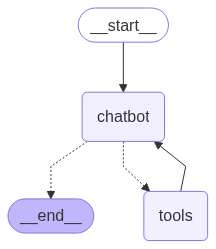

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
config = {"configurable": {"thread_id": "1"}}

In [24]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! Nice to meet you. How can I help you today?


In [25]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! How can I assist you today, Will?


In [26]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don’t have your name stored from this conversation. Could you please tell me your name? I’ll remember it for the rest of our chat!


In [27]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='fc511d23-c35d-474c-a710-96139c1fb15d'), AIMessage(content='Hello, Will! Nice to meet you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 775, 'total_tokens': 792, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_ccc6ec921d', 'id': 'chatcmpl-BYwOdBPdMGLUQCESF5dcVmjEhheDQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bf338ce1-a641-410f-ac19-10d1da99fb8a-0', usage_metadata={'input_tokens': 775, 'output_tokens': 17, 'total_tokens': 792, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {

In [28]:
snapshot.next

()